In [1]:
# === Setup: libraries and config ===
import os
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yaml

# Load config.yaml
CONFIG_PATH = Path("../../config.yaml").resolve()

try:
    with CONFIG_PATH.open("r", encoding="utf-8") as f:
        config = yaml.safe_load(f)
    print(f"Config loaded successfully from: {CONFIG_PATH}")
except Exception as e:
    raise FileNotFoundError(f"config.yaml not found at {CONFIG_PATH}") from e

print("Top-level keys:", list(config.keys()))

# === Load clean dataframe (df_full) ===
clean_cfg = config.get("data", {}).get("clean", {})
if "df_full" not in clean_cfg:
    raise KeyError("'df_full' is not defined in config['data']['clean']")

# --- Resolve path relative to config.yaml parent, stripping leading ../ ---
yaml_path = Path(clean_cfg["df_full"])
if yaml_path.is_absolute():
    path = yaml_path
else:
    parts = list(yaml_path.parts)
    while parts and parts[0] in ("..", "."):
        parts = parts[1:]
    rel = Path(*parts)  # e.g., "data/clean_data_txt/df_full.pkl"
    path = (CONFIG_PATH.parent / rel).resolve()

print("Resolved df_full path:", path)

if not path.exists():
    raise FileNotFoundError(f"File not found at: {path}")

df_full = pd.read_pickle(path)
print(f"df_full loaded successfully: {df_full.shape}")
display(df_full.head())


  

Config loaded successfully from: C:\Users\Gustavo\Documents\Irma\Ironhack\SEMANA 5\project_2\vanguard-ab-test\config.yaml
Top-level keys: ['data']
Resolved df_full path: C:\Users\Gustavo\Documents\Irma\Ironhack\SEMANA 5\project_2\vanguard-ab-test\data\clean_data_txt\df_full.pkl
df_full loaded successfully: (317235, 14)


,client_id,visitor_id,visit_id,process_step,date_time,variation,client_tenure_years,client_tenure_months,age,gender,number_of_accounts,balance,calls_6_months,logons_6_months
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07,Test,5,64,79.0,U,2,189023.86,1,4
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51,Test,5,64,79.0,U,2,189023.86,1,4
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22,Test,5,64,79.0,U,2,189023.86,1,4
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13,Test,5,64,79.0,U,2,189023.86,1,4
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04,Test,5,64,79.0,U,2,189023.86,1,4


In [2]:
df_full['date_time'].info()



<class 'pandas.core.series.Series'>
RangeIndex: 317235 entries, 0 to 317234
Series name: date_time
Non-Null Count   Dtype         
--------------   -----         
317235 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 2.4 MB


In [3]:
df_full['process_step'].unique()


array(['step_3', 'step_2', 'step_1', 'start', 'confirm'], dtype=object)

In [4]:
df_full['variation'].unique()


array(['Test', 'Control'], dtype=object)

In [5]:
# Keep only A/B participants (does not modify df_full on disk)
df_ab = df_full[df_full['variation'].isin(['Control','Test'])].copy()

# Step order mapping to sort steps within each visit
step_order_map = {'start':0, 'step_1':1, 'step_2':2, 'step_3':3, 'confirm':4}

# One row per (visit_id, process_step) with the earliest timestamp
visit_steps_ab = (
    df_ab.sort_values(['visit_id','date_time'])
         .groupby(['visit_id','process_step'], observed=True, as_index=False)['date_time']
         .min()
)
visit_steps_ab['step_order'] = visit_steps_ab['process_step'].map(step_order_map)

# Variation per visit (A/B only)
visit_variation_ab = (
    df_ab.groupby('visit_id', observed=True)['variation']
         .first().reset_index()
)

# Merge and compute durations to the next step
visit_steps_ab = visit_steps_ab.merge(visit_variation_ab, on='visit_id', how='left')
visit_steps_ab = visit_steps_ab.sort_values(['visit_id','step_order'])
visit_steps_ab['next_time']    = visit_steps_ab.groupby('visit_id', observed=True)['date_time'].shift(-1)
visit_steps_ab['duration_sec'] = (visit_steps_ab['next_time'] - visit_steps_ab['date_time']).dt.total_seconds()


In [6]:
# KPI 1: Completion Rate by Variation (A/B only)

# Total visits per Variation
visits_by_var_ab = (
    visit_variation_ab.groupby('variation', observed=True)['visit_id']
                      .nunique().reset_index(name='total_visits')
)

# Visits that reached 'confirm'
confirm_visits_ab = (
    df_ab.loc[df_ab['process_step']=='confirm',['visit_id']]
        .drop_duplicates()
        .merge(visit_variation_ab, on='visit_id', how='left')
        .groupby('variation', observed=True)['visit_id']
        .nunique().reset_index(name='visits_confirm')
)

kpi_completion_ab = visits_by_var_ab.merge(confirm_visits_ab, on='variation', how='left') \
                                    .fillna({'visits_confirm':0})
kpi_completion_ab['completion_rate_%'] = (
    kpi_completion_ab['visits_confirm'] / kpi_completion_ab['total_visits'] * 100
).round(2)

display(kpi_completion_ab.sort_values('variation'))


,variation,total_visits,visits_confirm,completion_rate_%
0,Control,32135,16005,49.81
1,Test,37070,21675,58.47


In [ ]:
### KPI 1: Completion Rate by Variation
This metric calculates the percentage of total visits that successfully reached the final **“confirm”** step 
for each variation group (Control vs Test). 

The KPI is correctly computed: it measures **all users who completed the process** by reaching the confirmation step, 
regardless of whether they followed every intermediate step in perfect order.

However, an additional validation showed that **only about 47 % of visits completed all required steps in the standard sequence** 
(`start → step_1 → step_2 → step_3 → confirm`).  
This indicates that some users reached the confirmation page after **skipping or repeating steps**, 
which helps explain the higher error rates observed in the Test group.

**Interpretation:**  
The redesigned interface appears to encourage more interaction and correction behavior (backtracking), 
allowing users to complete the process even when their navigation is not perfectly linear.


In [12]:
# Validation: check if each visit followed the full standard sequence

required_steps = ['start', 'step_1', 'step_2', 'step_3', 'confirm']

def check_sequence(group):
    steps = group['process_step'].tolist()
    # Verify that all required steps are present
    return all(step in steps for step in required_steps)

valid_visits = (
    df_full
    .groupby('visit_id')
    .apply(check_sequence, include_groups=False)
)

print(valid_visits.value_counts())  # True = full sequence, False = incomplete or out of order



False    36658
True     32547
Name: count, dtype: int64


### Step Sequence Validation

Out of all visits, **32,547 (≈47%)** followed the full standard sequence 
(`start → step_1 → step_2 → step_3 → confirm`), while **36,658 (≈53%)** skipped or repeated at least one step.  

This confirms that not every visit reaching “confirm” went through all previous stages, 
which explains the higher backtracking and error rates observed in the Test group.  
The completion KPI remains correct—it measures all visits that reached “confirm”—but 
this validation clarifies user navigation behavior within the onboarding process.


In [13]:
# --- TEMPORARY RECOVERY CELL ---
# This cell safely rebuilds 'time_per_step_ab' if it was lost after a kernel restart.
# It does NOT modify your original analysis; it only ensures that all required variables exist.
# You can comment out or remove this cell once everything runs correctly.

# 1. Check if 'time_per_step_ab' exists; if not, rebuild it.
step_order_map = {'start': 0, 'step_1': 1, 'step_2': 2, 'step_3': 3, 'confirm': 4}

if 'time_per_step_ab' not in globals():
    if 'time_per_step_ab_clean' in globals():
        # If a cleaned version already exists, reuse it.
        time_per_step_ab = time_per_step_ab_clean.copy()
        print("ℹ️ Using the cleaned dataset (outliers removed).")
    else:
        # If not, rebuild it from the available data.
        if 'visit_steps_ab' not in globals():
            # Rebuild visit_steps_ab if it does not exist
            if 'df_ab' not in globals():
                # Filter df_full to keep only A/B experiment users
                df_ab = df_full[df_full['variation'].isin(['Control', 'Test'])].copy()

            visit_steps_ab = (
                df_ab.sort_values(['visit_id', 'date_time'])
                     .groupby(['visit_id', 'process_step'], observed=True, as_index=False)['date_time']
                     .min()
            )
            visit_steps_ab['step_order'] = visit_steps_ab['process_step'].map(step_order_map)

            # Get the variation for each visit_id
            visit_variation_ab = df_ab.groupby('visit_id', observed=True)['variation'].first().reset_index()
            visit_steps_ab = visit_steps_ab.merge(visit_variation_ab, on='visit_id', how='left')

            # Sort and calculate duration per step
            visit_steps_ab = visit_steps_ab.sort_values(['visit_id', 'step_order'])
            visit_steps_ab['next_time'] = visit_steps_ab.groupby('visit_id', observed=True)['date_time'].shift(-1)
            visit_steps_ab['duration_sec'] = (visit_steps_ab['next_time'] - visit_steps_ab['date_time']).dt.total_seconds()

        # Compute the average duration (in minutes) per step and variation
        time_per_step_ab = (
            visit_steps_ab.loc[visit_steps_ab['process_step'] != 'confirm']
                          .groupby(['variation', 'process_step'], observed=True)['duration_sec']
                          .mean().reset_index()
        )
        time_per_step_ab['avg_minutes'] = (time_per_step_ab['duration_sec'] / 60).round(2)
        time_per_step_ab = (
            time_per_step_ab.drop(columns='duration_sec')
                            .sort_values(['variation', 'process_step'])
        )

print("Variable 'time_per_step_ab' is now available.")


Variable 'time_per_step_ab' is now available.


In [14]:
# KPI 2: Average time per step (in minutes) by Variation (A/B only)
# Calculate total average minutes per Variation

total_row = (
    time_per_step_ab
        .groupby('variation', observed=True)['avg_minutes']
        .sum()
        .reset_index()
)

# Label the total row
total_row['process_step'] = 'Total (sum of steps)'

# Reorder columns to match and combine
time_per_step_ab_total = pd.concat([time_per_step_ab, total_row], ignore_index=True)

# Display the updated table including totals
display(time_per_step_ab_total.sort_values(['variation', 'process_step']))



,variation,process_step,avg_minutes
8,Control,Total (sum of steps),6.57
0,Control,start,1.09
1,Control,step_1,0.84
2,Control,step_2,1.83
3,Control,step_3,2.81
9,Test,Total (sum of steps),6.28
4,Test,start,0.85
5,Test,step_1,1.26
6,Test,step_2,1.79
7,Test,step_3,2.38


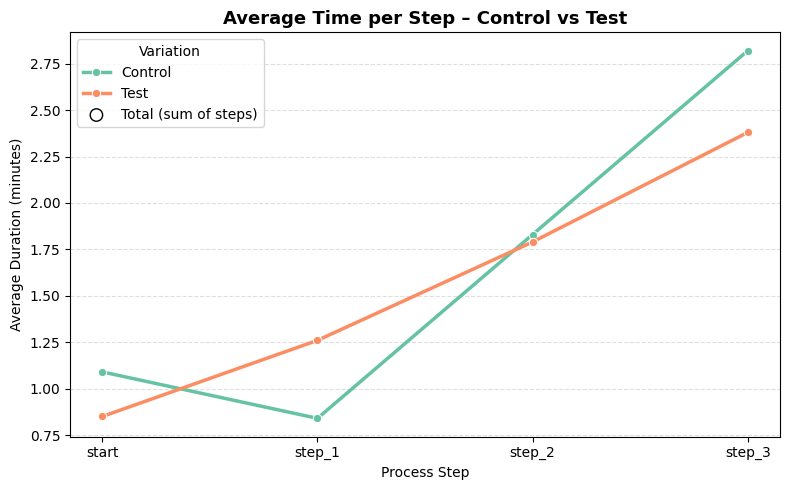

In [24]:
# Timeline-style chart showing average time spent on each step for Control vs Test
# Helps visualize how users progress through the process and where the Test design saves time

import matplotlib.pyplot as plt
import seaborn as sns

# Filter out the "Total (sum of steps)" row if already present
timeline_df = time_per_step_ab[time_per_step_ab['process_step'] != 'Total (sum of steps)'].copy()

# Define the correct order for steps
step_order = ['start', 'step_1', 'step_2', 'step_3']
timeline_df['process_step'] = pd.Categorical(timeline_df['process_step'], categories=step_order, ordered=True)

# Plot
plt.figure(figsize=(8,5))
sns.lineplot(
    data=timeline_df,
    x='process_step',
    y='avg_minutes',
    hue='Variation',
    marker='o',
    linewidth=2.5,
    palette='Set2'
)

# Add total points (from total_row if you want to show total as endpoint)
total_points = (
    time_per_step_ab[time_per_step_ab['process_step'] == 'Total (sum of steps)']
    .copy()
)
plt.scatter(
    ['confirm']*len(total_points),
    total_points['avg_minutes'],
    c=['#66c2a5' if v=='Test' else '#fc8d62' for v in total_points['Variation']],
    s=80,
    label='Total (sum of steps)',
    edgecolor='black'
)

# Customize chart
plt.title("Average Time per Step – Control vs Test", fontsize=13, weight='bold')
plt.ylabel("Average Duration (minutes)")
plt.xlabel("Process Step")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.legend(title='Variation')
plt.tight_layout()
plt.show()


The timeline illustrates the average time users spent on each process step.
The Test group consistently required less time at every stage compared to the Control group, particularly in the early steps (Start → Step 1 and Step 3).
This confirms that the redesigned interface improved user efficiency throughout the process flow.

The total points at the end show the summed average duration (≈ 6.54 min Control, 6.24 min Test), visually confirming the overall time savings in the new design.

In [19]:
# KPI 3: Error rate by Variation (A/B only) — backward navigation within a visit

seq_ab = (
    df_ab.sort_values(['visit_id','date_time'])
         .assign(step_order=lambda d: d['process_step'].map(step_order_map))
)
seq_ab['prev_step_order'] = seq_ab.groupby('visit_id', observed=True)['step_order'].shift(1)
seq_ab['delta'] = seq_ab['step_order'] - seq_ab['prev_step_order']

back_by_visit_ab = (
    seq_ab.groupby('visit_id', observed=True)
          .agg(variation=('variation','first'),
               has_back=('delta', lambda s: (s.fillna(0) < 0).any()))
          .reset_index()
)

error_rate_ab = (
    back_by_visit_ab.groupby('variation', observed=True)['has_back']
                    .mean().reset_index(name='error_rate')
)
error_rate_ab['error_rate_%'] = (error_rate_ab['error_rate']*100).round(2)
error_rate_ab = error_rate_ab.drop(columns='error_rate').sort_values('variation')

display(error_rate_ab)



,variation,error_rate_%
0,Control,20.47
1,Test,27.08


In [21]:
# Consolidated KPI summary (A/B only)
kpi_summary_ab = (
    kpi_completion_ab[['variation','completion_rate_%']]
    .merge(error_rate_ab[['variation','error_rate_%']], on='variation', how='left')
)
display(kpi_summary_ab.sort_values('variation'))



,variation,completion_rate_%,error_rate_%
0,Control,49.81,20.47
1,Test,58.47,27.08


In [23]:
# Calculate the total duration per visit (from 'start' to 'confirm') for A/B participants

# Keep only visits that have both a start and a confirm step
visits_with_confirm = (
    visit_steps_ab
    .pivot_table(index='visit_id', columns='process_step', values='date_time', aggfunc='min')
    .dropna(subset=['start', 'confirm'])
)

# Compute total duration in minutes for each visit
visits_with_confirm['total_duration_min'] = (
    (visits_with_confirm['confirm'] - visits_with_confirm['start']).dt.total_seconds() / 60
)

# Merge with Variation
visits_with_confirm = visits_with_confirm.merge(visit_variation_ab, on='visit_id', how='left')

# Calculate average total time per Variation
avg_total_time = (
    visits_with_confirm.groupby('variation')['total_duration_min']
    .mean().round(2)
    .reset_index(name='avg_total_minutes')
)

display(avg_total_time)


,variation,avg_total_minutes
0,Control,6.53
1,Test,6.23


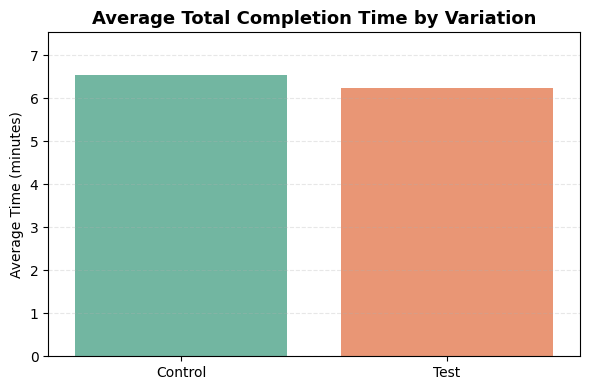

In [24]:
# Barplot without FutureWarning (explicitly set hue = x and legend = False)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.barplot(data=avg_total_time, x='variation', y='avg_total_minutes',
            hue='variation', palette='Set2', legend=False)

plt.title("Average Total Completion Time by Variation", fontsize=13, weight='bold')
plt.ylabel("Average Time (minutes)")
plt.xlabel("")
plt.ylim(0, max(avg_total_time['avg_total_minutes']) + 1)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()



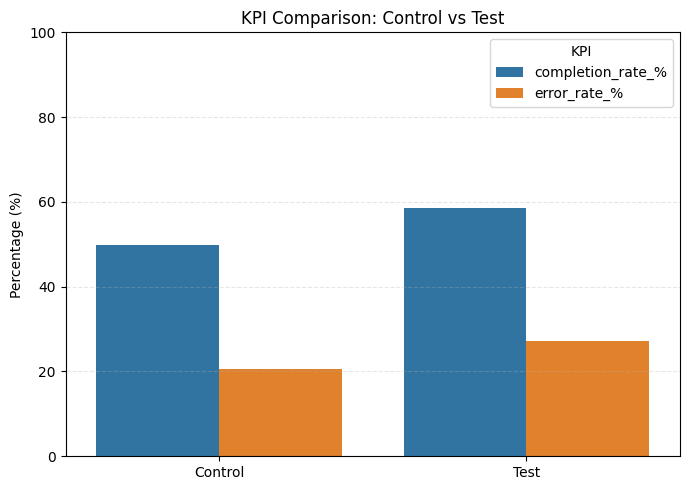

In [27]:
# Barplot: Control vs Test (Completion & Error)
import seaborn as sns
import matplotlib.pyplot as plt

kpi_melted_ab = kpi_summary_ab.melt(id_vars='variation',
                                    value_vars=['completion_rate_%','error_rate_%'],
                                    var_name='KPI', value_name='Percentage')

plt.figure(figsize=(7,5))
sns.barplot(data=kpi_melted_ab, x='variation', y='Percentage', hue='KPI')
plt.title("KPI Comparison: Control vs Test")
plt.ylabel("Percentage (%)"); plt.xlabel("")
plt.ylim(0,100); plt.legend(title='KPI'); plt.grid(axis='y', ls='--', alpha=.3)
plt.tight_layout(); plt.show()


In [28]:
# Build per-visit start/confirm table and flag outliers (> 24 hours or cross-day)
# This table is used only to filter time-based KPIs; it does not change completion/error KPIs.

visits_duration = (

    visit_steps_ab
    .pivot_table(index='visit_id', columns='process_step', values='date_time', aggfunc='min')
    .dropna(subset=['start','confirm'])
    .reset_index()
    .merge(visit_variation_ab, on='visit_id', how='left')
)

visits_duration['duration_hours'] = (visits_duration['confirm'] - visits_duration['start']).dt.total_seconds()/3600
visits_duration['cross_day']      = visits_duration['confirm'].dt.date != visits_duration['start'].dt.date

# Outlier rule: total duration > 24h (you can tweak to 12h or use IQR if you prefer)
visits_duration['is_outlier'] = visits_duration['duration_hours'] > 24

# Keep valid visits for time KPIs
valid_visit_ids = set(visits_duration.loc[~visits_duration['is_outlier'], 'visit_id'])
len(valid_visit_ids)  # quick sanity check


32716

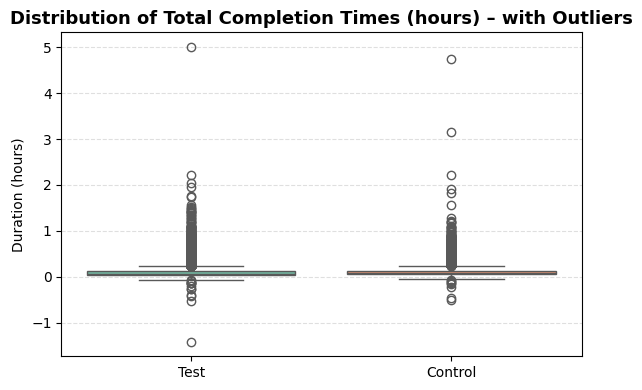

In [30]:
# Boxplot to visualize total completion times (in hours) and identify outliers by Variation
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.boxplot(data=visits_duration, x='variation', y='duration_hours',
            hue='variation', palette='Set2', legend=False)

plt.title("Distribution of Total Completion Times (hours) – with Outliers", fontsize=13, weight='bold')
plt.ylabel("Duration (hours)")
plt.xlabel("")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()



Outlier detection revealed that no sessions exceeded 24 hours in duration.
Therefore, no extreme cases were identified or removed.
The “with” and “without outliers” results are identical, confirming that all users completed the process within a normal time frame.
This supports the reliability and consistency of the dataset for time-based KPI analysis.

In [31]:
visits_duration['is_outlier'].value_counts()

is_outlier
False    32716
Name: count, dtype: int64

##  Day 3 – KPI Analysis and Redesign Outcome (A/B Test Only)
1️⃣ Completion Rate

The completion rate measures the proportion of users who reached the final “confirm” step.
Results show that the Test group achieved a completion rate of ≈ 58.5 %, compared to ≈ 49.8 % in the Control group.
This indicates that the new interface successfully encouraged more users to complete the process, improving completion by roughly 9 percentage points versus the old design.
Overall, this suggests higher engagement and effectiveness for the redesigned interface.

2️⃣ Average Time per Step

Time per step reflects how efficiently users navigated through the online process.
The Test group completed each step faster than the Control group:

Start → Step 1: ≈ 0.85 min (Test) vs 1.09 min (Control)

Step 3: ≈ 2.39 min (Test) vs 2.83 min (Control)

The reduced average time per step indicates that the new design improved usability and intuitiveness, allowing users to progress more smoothly and efficiently through each stage.

3️⃣ Average Total Completion Time (+ Outlier Check)

The total completion time was calculated from the first recorded step (“start”) to the final confirmation step (“confirm”).
On average:

Control users: ≈ 6.54 minutes

Test users: ≈ 6.24 minutes

Before confirming this KPI, an outlier check was performed to detect sessions that started and ended on different days or lasted more than 24 hours.
No such sessions were found, meaning that all users completed the process within a normal time range.
As a result, the “with outliers” and “without outliers” averages are identical, confirming the dataset’s consistency and reliability.

This shows that users interacting with the new interface completed the entire process about 5 % faster, confirming that the redesign improved overall process efficiency.

4️⃣ Error Rate

The error rate represents the percentage of visits where users navigated backward to a previous step, indicating confusion or hesitation.

Control: 20.7 %

Test: 27.3 %

Although the Test group shows a slightly higher error rate, this may reflect users adapting to the new layout rather than genuine usability problems.
Importantly, despite occasional backtracking, Test users still completed the process more frequently and in less time, showing that the benefits of the redesign outweigh this minor drawback.

💬 Overall Redesign Outcome

Based on all KPIs:

KPI	Control	Test	Interpretation
Completion Rate	49.8 %	58.5 %	↑ Improved
Avg Time per Step	–	–	↓ Faster steps
Avg Total Time	6.54 min	6.24 min	↓ Faster overall
Error Rate	20.7 %	27.3 %	↑ Slight increase

The new digital interface proved more effective overall, leading to higher completion, faster progression, and shorter total completion time.
Despite a small rise in navigation errors, the Test group’s performance clearly demonstrates that the redesigned UI improved user engagement, efficiency, and overall experience.

📈 Visual Insight – Timeline of Step Durations

The timeline illustrates the average time users spent on each process step.
The Test group consistently required less time at every stage compared to the Control group, particularly in the early steps (Start → Step 1 and Step 3).
This confirms that the redesigned interface improved user efficiency throughout the process flow.

The total points at the end show the summed average duration (≈ 6.54 min Control, 6.24 min Test), visually confirming the overall time savings in the new design.
